In [1]:
import networkx as nx
import dwave_networkx as dnx
import random
import matplotlib.pyplot as plt
import pulp
import numpy as np

from lpSolver import solve
from uccgGenerator import tree_insertion, Graph
from plotNetwork import plotGraph, plotCoupling

In [2]:
def markov_chain_add_remove_simplicial(g_):
    g = Graph(g_)
    simplicial_vertices = filter(lambda v: dnx.is_simplicial(g, v), g.nodes)
    v = random.choice(list(simplicial_vertices))
    edges = set(g.edges(v))
    g.remove_edges_from(edges)
    g.remove_node(v)
    cliques = list(g.edges)
#     cliques.extend([[u] for u in g.nodes])
    c = random.sample(cliques, 1)[0]
    g.add_edges_from([(u, v) for u in c])
    g.move = f"reattach {v} to {c}"
    return g

In [3]:
def get_children(g, lambd=1):
    simplicial_vertices = list(filter(lambda v: dnx.is_simplicial(g, v), g.nodes))
    n_pre = len(simplicial_vertices)
    children = []
    visited = set()
    total_prob = 0
    self_loop = None
    for v in simplicial_vertices:
        cg = Graph(g)
        n = len(cg.nodes)
        edges = set(g.edges(v))
        cg.remove_edges_from(edges)
        cg.remove_node(v)
        cliques = list(cg.edges)
#         cliques.extend([[u] for u in cg.nodes])
        m = len(cliques)
        for c in cliques:
            g_child = Graph(cg)
            g_child.add_edges_from([(u, v) for u in c])
            sv_now = list(filter(lambda v: dnx.is_simplicial(g_child, v), g_child.nodes))
            n_post = len(sv_now)
            if g_child in visited:
                continue
            visited.add(g_child)
            children.append(g_child)
            if g_child != g:
                g_child.prob = 1/(n*m) * min(1, lambd**(n_post-n_pre))
                g_child.move = f"reattach {v} to {c}"
                total_prob += g_child.prob
            else:
                self_loop = g_child
    self_loop.prob = 1 - total_prob
    self_loop.move = "stay"
    return children

In [4]:
def markov_chain_dist(g1, g2, lambd=1):
    visited = set()
    queue = [(g1, 0)]
    while queue:
        head, dist = queue.pop(0)
        if head == g2:
            return dist
        children = get_children(head, lambd)
        for child in children:
            if child not in visited:
                visited.add(child)
                queue.append((child, dist+1))
    return -1

In [9]:
g1 = tree_insertion(6, 9)
for _ in range(5):
    g1 = markov_chain_add_remove_simplicial(g1)
g2 = markov_chain_add_remove_simplicial(g1)
markov_chain_dist(g1, g2, lambd=1)

1

reattach 1 to (4, 3)


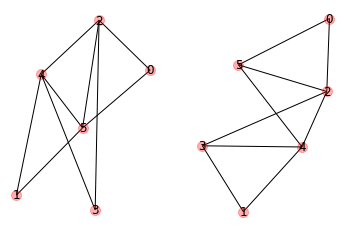

In [10]:
plt.figure()
plt.subplot(1,2,1)
plotGraph(g1)
plt.subplot(1,2,2)
plotGraph(g2)
print(g2.move)

In [11]:
lambd = 1
g1_children = get_children(g1, lambd)
g2_children = get_children(g2, lambd)
l1, l2 = len(g1_children), len(g2_children)
print(l1, l2)
dists = np.zeros((l1, l2))
for i in range(l1):
    for j in range(l2):
        dists[i][j] = markov_chain_dist(g1_children[i], g2_children[j], lambd)

19 13


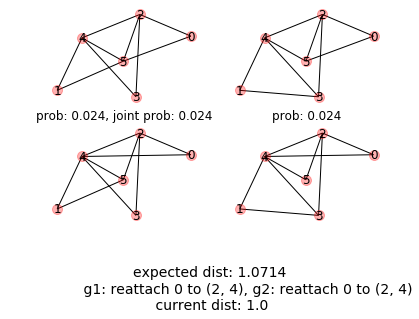

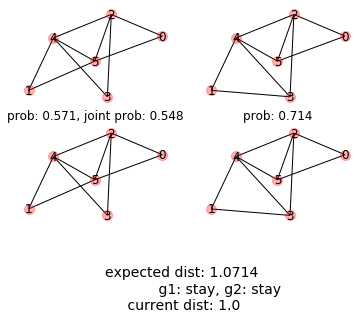

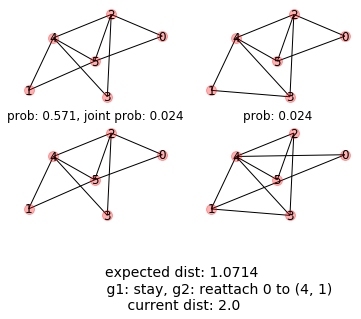

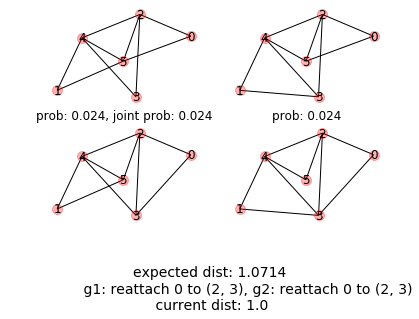

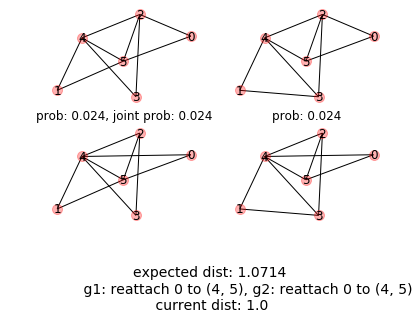

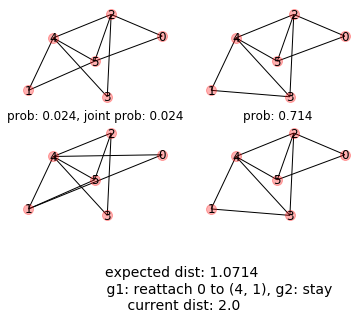

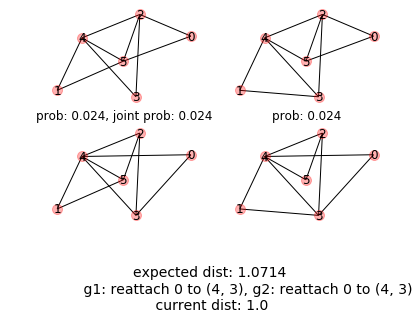

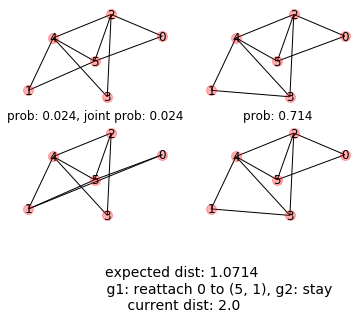

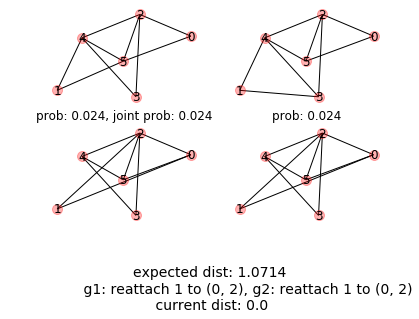

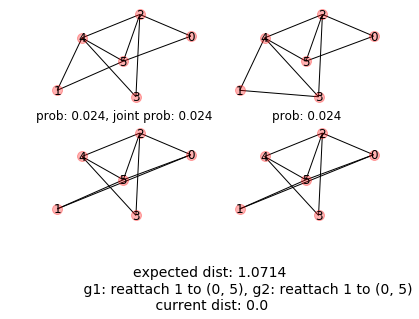

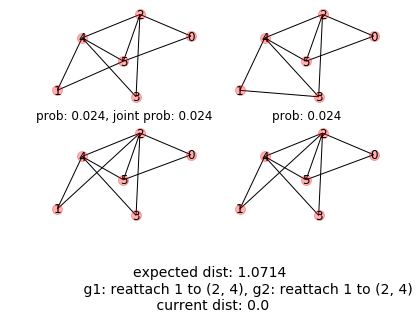

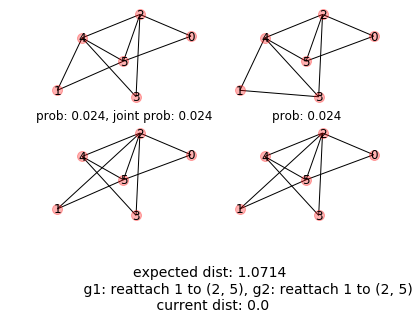

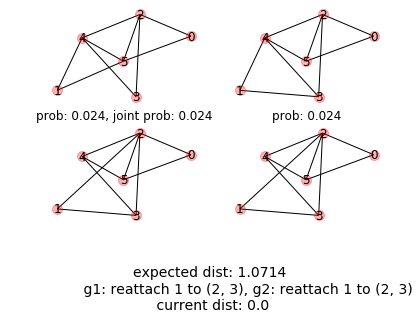

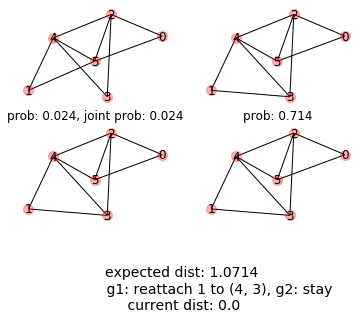

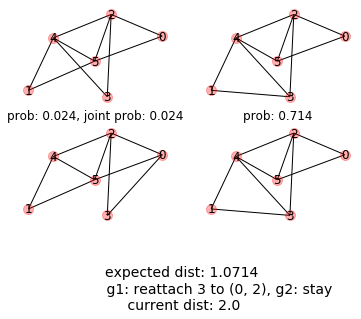

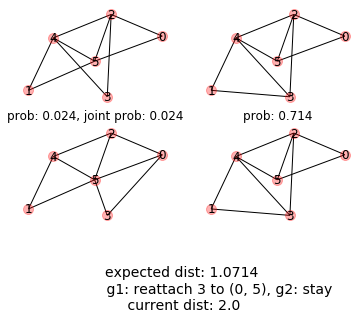

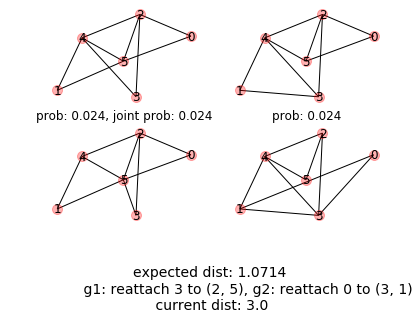

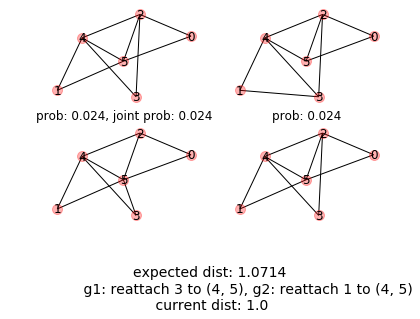

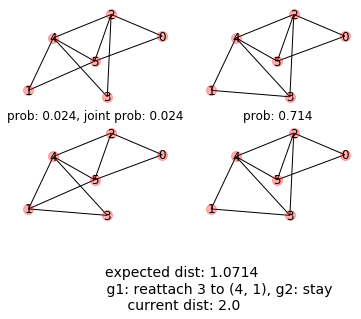

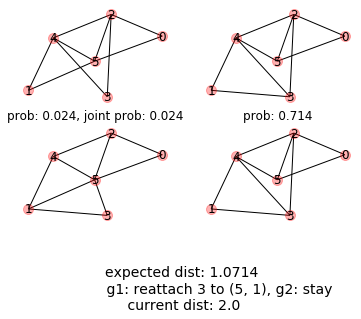

In [12]:
status, dist, joint_prob = solve(g1_children, g2_children, dists)
plotCoupling(g1, g2, g1_children, g2_children, dists, joint_prob, dist)
! rm *.png